# Plus = add interannual variablity,Analysis of Monthly Mean Historical Meteorologic Variables from LOCA and BCSD

This notebook analyzes meteorologic variables from the historical scenario (1950-2005) from the LOCA and BCSD datasets. Each dataset is compared to its respective gridded observations used for training -- Livneh observations for LOCA and Maurer observations for BCSD.

Variables include:
- Precipitation
- Temperature

In [5]:
from loca import print_date
print_date()

Last executed: 2019-10-04 22:05:36.960437 by jvano on casper10


# Imports and Options

In [6]:
%matplotlib inline

%load_ext autoreload
%autoreload 2

import os
import matplotlib.pyplot as plt
import cmocean

import xarray as xr

from loca.data_catalog import load_monthly_historical_met_datasets, load_daily_livneh_meteorology, resample_monthly_data
from loca.utils import calc_change
from loca.plot import make_plot, PROJECTION, add_ylabel
from cmocean import cm

# models currently using:
# models = ['ACCESS1-0', 'CanESM2', 'MIROC5', 'MRI-CGCM3', 'bcc-csm1-1'] 

# list of 23:
# models = ['ACCESS1-0', 'CanESM2', 'MIROC5', 'MRI-CGCM3', 'bcc-csm1-1', 'bcc-csm1-1-m',
#           'CESM1-BGC', 'CMCC-CM', 'HadGEM2-CC', 'HadGEM2-ES', 'inmcm4', 'IPSL-CM5A-MR',
#           'MIROC-ESM', 'MIROC-ESM-CHEM', 'MPI-ESM-LR', 'MPI-ESM-MR', 'NorESM1-M', 'GFDL-ESM2G', 
#           'CNRM-CM5', 'CSIRO-Mk3-6-0', 'GFDL-ESM2M','GFDL-CM3', 'HadGEM2-AO']

models = ['ACCESS1-0', 'CanESM2', 'MIROC5']

#cache is written in script "write_cache.ipynb"
read_cache = True
# cache_dir = os.environ['TMPDIR']
cache_dir = '/glade/u/home/jvano/scratch/'

met_vars = ['pcp', 't_mean']

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
from dask.distributed import Client
client = Client(scheduler_file=os.path.join(os.environ['HOME'], 'scheduler_file.json'))
client

Client Scheduler: tcp://128.117.181.216:38197 Dashboard: proxy/8787/status,Cluster Workers: 2 Cores: 4 Memory: 60.00 GB


# Load Data

In [8]:
hist_cmip_met_data = {}
if read_cache:
    print("reading values from cache")
    for key in ['loca', 'bcsd']:
        hist_cmip_met_data[key] = xr.open_mfdataset(
            os.path.join(cache_dir, f'monthly_cmip_met_hist.{key}_*.nc'),
            concat_dim='gcm', chunks={'time': 72})
    print("finished reading from cache")
    ds = hist_cmip_met_data['loca']
    print(ds['pcp'])
    #TODO once get obs load separate won't have to do work around below
    single = ['ACCESS1-0']
    obs_data = load_monthly_historical_met_datasets(models=single, autoclose=True, parallel=True)
    print("finished reading obs")

else:
    print("reading values from files directly")
    met_data = load_monthly_historical_met_datasets(models=models, autoclose=True, parallel=True)

reading values from cache
finished reading from cache
<xarray.DataArray 'pcp' (gcm: 23, time: 672, lat: 224, lon: 464)>
dask.array<shape=(23, 672, 224, 464), dtype=float64, chunksize=(1, 72, 224, 464)>
Coordinates:
  * time     (time) datetime64[ns] 1950-01-01 1950-02-01 ... 2005-12-01
  * lon      (lon) float64 -124.9 -124.8 -124.7 -124.6 ... -67.31 -67.19 -67.06
  * lat      (lat) float64 25.06 25.19 25.31 25.44 ... 52.56 52.69 52.81 52.94
  * gcm      (gcm) <U14 'ACCESS1-0' 'CESM1-BGC' ... 'bcc-csm1-1' 'inmcm4'
load_monthly_historical_met_datasets
load_monthly_cmip_met_datasets
load_monthly_loca_meteorology
load_daily_loca_meteorology
load_monthly_bcsd_meteorology
load_bcsd_dataset
load_monthly_livneh_meteorology
load_daily_livneh_meteorology
load_monthly_maurer_meteorology
load_daily_maurer_meteorology
finished reading obs


In [9]:
# merging
met_data = {**obs_data, **hist_cmip_met_data}

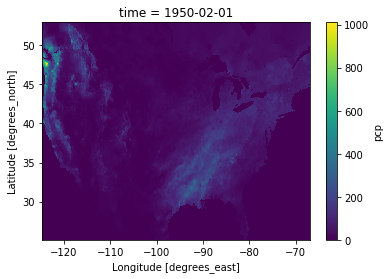

In [10]:
# met_data['maurer']['t_min'].isel(time=1).plot()
met_data['maurer']['pcp'].isel(time=1).plot()

In [11]:
epoch = slice('1970-01-01', '1999-12-31') # annual year 
print("finished slice")

mask = met_data['bcsd']['t_mean'].isel(gcm=0, time=0).squeeze().notnull()

epoch_means = dict((k, resample_monthly_data(ds.sel(time=epoch), freq='AS',
                                             chunks={'lat': 100, 'lon': 100}).mean('time').where(mask).persist()) for (k, ds) in met_data.items())
print("finished epoch_means")
ens_means = {"bcsd": epoch_means['bcsd'].mean('gcm'),"loca": epoch_means['loca'].mean('gcm')}

# ens_means = dict((k, resample_monthly_data(ds.sel(time=epoch), freq='AS', chunks={'lat': 100, 'lon': 100}).mean('time').mean('gcm').where(mask).persist()) for (k, ds) in hist_cmip_met_data.items())
print("finished ens means mean")
# ens_mean_std = dict((k, resample_monthly_data(ds.sel(time=epoch), freq='AS', chunks={'lat': 100, 'lon': 100}).mean('time').std('gcm').where(mask).persist()) for (k, ds) in hist_cmip_met_data.items())
ens_means_std = {"bcsd": epoch_means['bcsd'].std('gcm'),"loca": epoch_means['loca'].std('gcm')}
print("finished ens mean std")

# for debugging
# epoch_means = {}
# for k, ds in met_data.items():
#     print(k, flush=True)
#     epoch_means[k] = ds.sel(time=epoch).mean('time').where(mask).compute()

finished slice
finished epoch_means
finished ens means mean
finished ens mean std


In [12]:
# calculate interannual variability
# from Ethan: ds["pcp"].resample(time="YS").sum(dim="time").std(dim="time"
                                          
epoch_interannual = dict((k, resample_monthly_data(ds.sel(time=epoch), freq='AS',
                                                   chunks={'lat': 100, 'lon': 100}).std('time').where(mask).persist()) for (k, ds) in met_data.items())
print("finished epoch_interannual")

# ens_interannual_means = dict((k, resample_monthly_data(ds.sel(time=epoch), freq='AS', 
#                                                        chunks={'lat': 100, 'lon': 100}).std('time').mean('gcm').where(mask).persist()) for (k, ds) in hist_cmip_met_data.items())

ens_interannual_means  = {"bcsd": epoch_interannual['bcsd'].mean('gcm'),"loca": epoch_interannual['loca'].mean('gcm')}
print("finished ens interannual mean")

# ens_interannual_std = dict((k, resample_monthly_data(ds.sel(time=epoch), freq='AS', 
#                                                        chunks={'lat': 100, 'lon': 100}).std('time').std('gcm').where(mask).persist()) for (k, ds) in hist_cmip_met_data.items())
ens_interannual_std = {"bcsd": epoch_interannual['bcsd'].std('gcm'),"loca": epoch_interannual['loca'].std('gcm')}
print("finished ens interannual std")

finished epoch_interannual
finished ens interannual mean
finished ens interannual std


# Plots

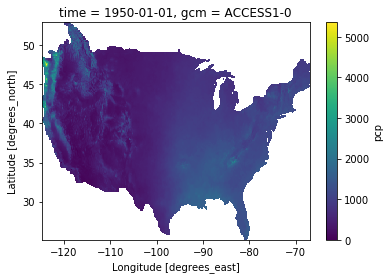

In [11]:
epoch_means['maurer']['pcp'].plot() 

'test3'

'test4'

'test4'

'test1'

'test2'

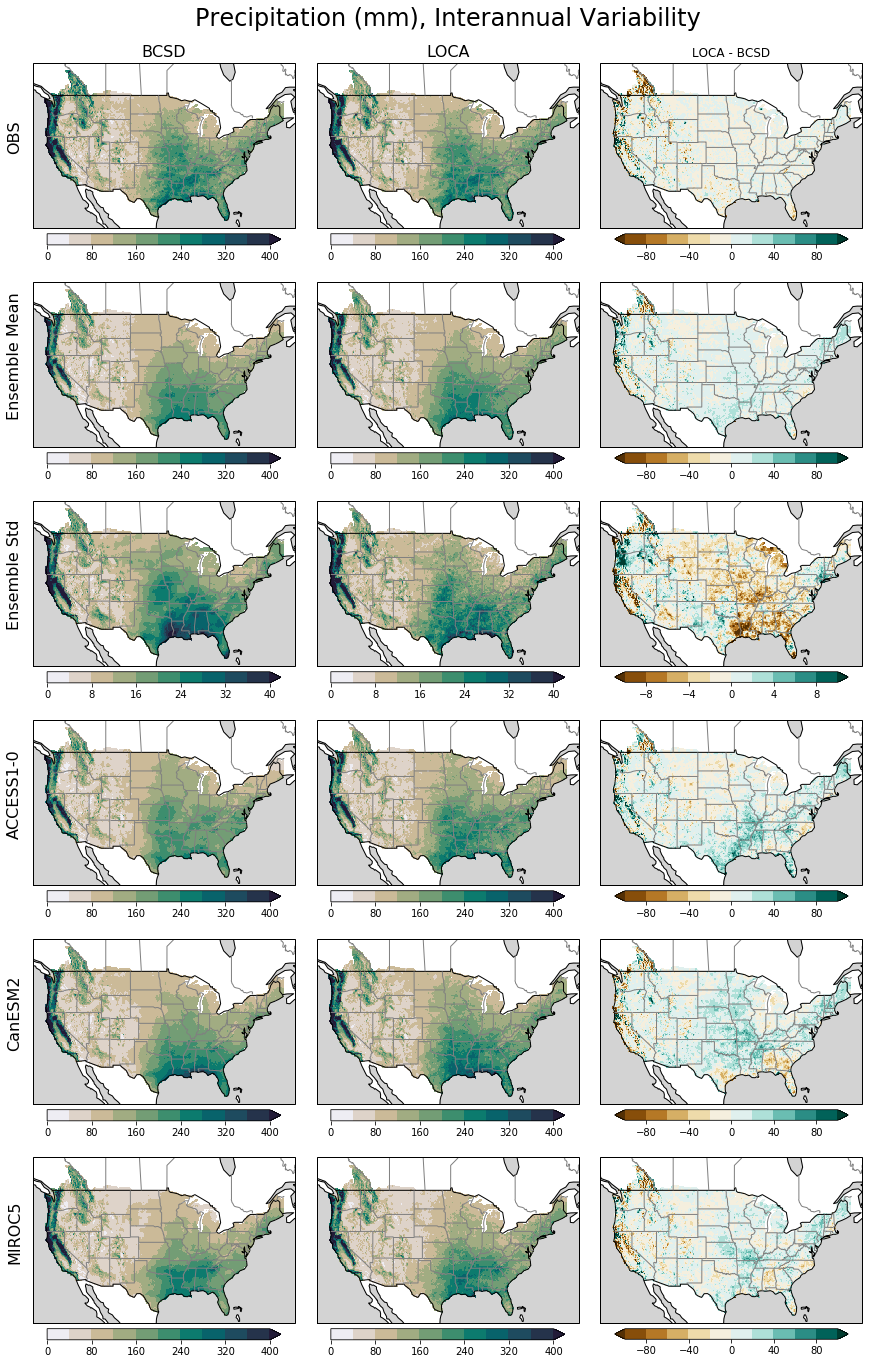

In [25]:
# Interannual Variability with differences 

watercmap = cm.rain  #https://matplotlib.org/cmocean/
watercmapdiff = 'BrBG'
tempcmapdiff = 'RdBu_r'

variablename = {'t_mean': 'Temperature (C)', 'pcp': 'Precipitation (mm)'}
style_kwargs =  {'levels': 11, 'add_labels': False, 'cbar_kwargs': dict(orientation="horizontal", shrink=0.85, pad=0.03)}

models = ['ACCESS1-0', 'CanESM2', 'MIROC5']

# models = ['ACCESS1-0', 'CanESM2', 'MIROC5', 'MRI-CGCM3', 'bcc-csm1-1', 'bcc-csm1-1-m', 'CCSM4',
#           'CESM1-BGC', 'CMCC-CM', 'GISS-E2-R', 'HadGEM2-CC', 'HadGEM2-ES', 'inmcm4', 'IPSL-CM5A-MR',
#           'MIROC-ESM', 'MIROC-ESM-CHEM', 'MPI-ESM-LR', 'MPI-ESM-MR', 'NorESM1-M', 'GFDL-ESM2G', 
#           'CNRM-CM5', 'CSIRO-Mk3-6-0', 'GFDL-ESM2M','GFDL-CM3', 'HadGEM2-AO']

kwargs = {'pcp': {'vmin': 0, 'vmax': 400, 'cmap': watercmap, **style_kwargs},
          't_mean': {'vmin': -10, 'vmax': 20, 'extend': 'both', **style_kwargs},}

kwargs2 = {'pcp': {'vmin': 0, 'vmax': 40, 'cmap': watercmap,  **style_kwargs}, 
            't_mean': {'vmin': -1, 'vmax': 1, 'extend': 'both', **style_kwargs}}

units = {'pcp': 'mm', 't_mean': 'C'}

diff_kws = {'pcp': {'vmin': -100, 'vmax': 100, 'cmap': watercmapdiff, 'extend': 'both', **style_kwargs}, 
            't_mean': {'vmin': -1, 'vmax': 1, 'cmap': tempcmapdiff,  'extend': 'both', **style_kwargs}}



diff3_kws = {'pcp': {'vmin': -10, 'vmax': 10, 'cmap': watercmapdiff, 'extend': 'both', **style_kwargs}, 
            't_mean': {'vmin': -1, 'vmax': 1, 'cmap': tempcmapdiff,  'extend': 'both', **style_kwargs}}

nrows = 3 + len(models)
ncols = 3

# met_vars = ['t_mean', 'pcp']
met_vars = ['pcp']
for var in met_vars:
    
    fig, axes = plt.subplots(ncols=ncols, nrows=nrows, sharex=True, sharey=True, figsize=(4*ncols, 3.1*nrows), subplot_kw={'projection': PROJECTION})
        
    for col, (title, obs_data, ens_mean, ens_std, ds_data) in enumerate([('BCSD', epoch_interannual['maurer'], ens_interannual_means['bcsd'], 
                                                                          ens_interannual_std['bcsd'], epoch_interannual['bcsd']),
                                                                         ('LOCA', epoch_interannual['livneh'], ens_interannual_means['loca'], 
                                                                          ens_interannual_std['loca'], epoch_interannual['loca'])]):

#     for col, (title, obs_data, ens_mean, ens_std, ds_data) in enumerate([('BCSD', epoch_interannual['maurer'], epoch_interannual['maurer'], epoch_interannual['maurer'], epoch_interannual['bcsd']),
#                                                                          ('LOCA', epoch_interannual['livneh'], epoch_interannual['livneh'], ens_interannual_std['loca'], epoch_interannual['loca'])]):

        ax = axes[0, col]
        make_plot(obs_data[var], ax=ax, plot_kwargs=kwargs[var]) 
#         obs_data[var].plot.pcolormesh(ax=ax, add_labels=False, **kwargs[var])
        ax.set_title(title, fontsize=16)
        
        if col == 0:
#             ax.set_ylabel('OBS')
            add_ylabel(ax, 'OBS', fontsize=16)
            display ('test3')
            
        ax = axes[1, col]
        make_plot(ens_mean[var], ax=ax, plot_kwargs=kwargs[var]) 
#         ens_mean[var].plot.pcolormesh(ax=ax, add_labels=False, **kwargs[var])
#         ens_mean[var].plot.pcolormesh(ax=ax, add_labels=False)
        if col == 0:
#             ax.set_ylabel('Ensemble Mean')
            add_ylabel(ax, 'Ensemble Mean', fontsize=16)
            display ('test4')
            
        ax = axes[2, col]
        make_plot(ens_std[var], ax=ax, plot_kwargs=kwargs2[var]) 
#         ens_std[var].plot.pcolormesh(ax=ax, add_labels=False)
#         ens_std[var].plot.pcolormesh(ax=ax, add_labels=False, vmin=0, vmax=40)
        if col == 0:
#             ax.set_ylabel('Ensemble Std')
            add_ylabel(ax, 'Ensemble Std', fontsize=16)
            display ('test4')
        
        for row, model in enumerate(models, 3):
            ax = axes[row, col]
            make_plot(ds_data[var].sel(gcm=model), ax=ax, plot_kwargs=kwargs[var]) 
#             ds_data[var].sel(gcm=model).plot.pcolormesh(ax=ax, add_labels=False, **kwargs[var])
            
            if col == 0:
                add_ylabel(ax, model, fontsize=16)
#                 ax.set_ylabel(model)
                
    display ('test1')
# ATTEMPT TO ADD DIFF        
    ax = axes[0, -1]
#     calc_change(epoch_interannual['maurer'][var], epoch_interannual['livneh'][var]).plot.pcolormesh(ax=ax, add_labels=False, **diff_kws[var])
    make_plot(calc_change(epoch_interannual['maurer'][var], epoch_interannual['livneh'][var]), ax=ax, plot_kwargs=diff_kws[var]) 
    ax.set_title('LOCA - BCSD')  
        
    ax = axes[1, -1]
#     calc_change(ens_interannual_means['bcsd'][var], ens_interannual_means['loca'][var]).plot.pcolormesh(ax=ax, add_labels=False, **diff_kws[var])
    make_plot(calc_change(ens_interannual_means['bcsd'][var], ens_interannual_means['loca'][var]), ax=ax, plot_kwargs=diff_kws[var]) 
    
    ax = axes[2, -1]
#     calc_change(ens_interannual_std['bcsd'][var], ens_interannual_std['loca'][var]).plot.pcolormesh(ax=ax, add_labels=False, vmin=-10, vmax=10, cmap= 'RdBu')
    make_plot(calc_change(ens_interannual_std['bcsd'][var], ens_interannual_std['loca'][var]), ax=ax, plot_kwargs=diff3_kws[var]) 
    
    diff = calc_change(epoch_interannual['bcsd'][var], epoch_interannual['loca'][var]).persist()
    display ('test2')
    for row, model in enumerate(models, 3):
        ax = axes[row, -1]  
#         diff.sel(gcm=model).plot.pcolormesh(ax=ax, add_labels=False, **diff_kws[var])
        make_plot(diff.sel(gcm=model), ax=ax, plot_kwargs=diff_kws[var]) 

    title = variablename[var]
    title += ', Interannual Variability'
    unit_str = units[var]
    fig.suptitle(title, fontsize=24, y=1.02)
    fig.tight_layout()     
    fig.savefig(f'/glade/u/home/jvano/workdir/loca_figs/{var}_{unit_str}_mon_hist_met_ens_interannual.png', dpi=300, bbox_inches='tight')

In [ ]:
# Interannual Variability with differences 

watercmap = cm.rain  #https://matplotlib.org/cmocean/
watercmapdiff = 'BrBG'
tempcmapdiff = 'RdBu_r'

variablename = {'t_mean': 'Temperature (C)', 'pcp': 'Precipitation (mm)'}
style_kwargs =  {'levels': 11, 'add_labels': False, 'cbar_kwargs': dict(orientation="horizontal", shrink=0.85, pad=0.03)}

models = ['ACCESS1-0', 'CanESM2', 'MIROC5']

# models = ['ACCESS1-0', 'CanESM2', 'MIROC5', 'MRI-CGCM3', 'bcc-csm1-1', 'bcc-csm1-1-m', 'CCSM4',
#           'CESM1-BGC', 'CMCC-CM', 'GISS-E2-R', 'HadGEM2-CC', 'HadGEM2-ES', 'inmcm4', 'IPSL-CM5A-MR',
#           'MIROC-ESM', 'MIROC-ESM-CHEM', 'MPI-ESM-LR', 'MPI-ESM-MR', 'NorESM1-M', 'GFDL-ESM2G', 
#           'CNRM-CM5', 'CSIRO-Mk3-6-0', 'GFDL-ESM2M','GFDL-CM3', 'HadGEM2-AO']

kwargs = {'pcp': {'vmin': 0, 'vmax': 400},
          't_mean': {'vmin': -10, 'vmax': 20},}
units = {'pcp': 'mm', 't_mean': 'C'}

diff_kws = {'pcp': {'vmin': -100, 'vmax': 100, 'cmap': 'RdBu'}, 't_mean': {'vmin': -1, 'vmax': 1, 'cmap': 'RdBu_r'}}

nrows = 3 + len(models)
ncols = 3

# met_vars = ['t_mean', 'pcp']
met_vars = ['pcp']
for var in met_vars:
    
    fig, axes = plt.subplots(ncols=ncols, nrows=nrows, sharex=True, sharey=True, figsize=(4*ncols, 2*nrows))
        
    for col, (title, obs_data, ens_mean, ens_std, ds_data) in enumerate([('BCSD', epoch_interannual['maurer'], ens_interannual_means['bcsd'], 
                                                                          ens_interannual_std['bcsd'], epoch_interannual['bcsd']),
                                                                         ('LOCA', epoch_interannual['livneh'], ens_interannual_means['loca'], 
                                                                          ens_interannual_std['loca'], epoch_interannual['loca'])]):

#     for col, (title, obs_data, ens_mean, ens_std, ds_data) in enumerate([('BCSD', epoch_interannual['maurer'], epoch_interannual['maurer'], epoch_interannual['maurer'], epoch_interannual['bcsd']),
#                                                                          ('LOCA', epoch_interannual['livneh'], epoch_interannual['livneh'], ens_interannual_std['loca'], epoch_interannual['loca'])]):

        ax = axes[0, col]
        obs_data[var].plot.pcolormesh(ax=ax, add_labels=False, **kwargs[var])
        ax.set_title(title)
        
        if col == 0:
            ax.set_ylabel('OBS')
            display ('test3')
            
        
        ax = axes[1, col]
        ens_mean[var].plot.pcolormesh(ax=ax, add_labels=False, **kwargs[var])
#         ens_mean[var].plot.pcolormesh(ax=ax, add_labels=False)
        if col == 0:
            ax.set_ylabel('Ensemble Mean')
            display ('test4')
            
        ax = axes[2, col]
#         ens_std[var].plot.pcolormesh(ax=ax, add_labels=False)
        ens_std[var].plot.pcolormesh(ax=ax, add_labels=False, vmin=0, vmax=40)
        if col == 0:
            ax.set_ylabel('Ensemble Std')
            display ('test4')
        
        for row, model in enumerate(models, 3):
            ax = axes[row, col]
            ds_data[var].sel(gcm=model).plot.pcolormesh(ax=ax, add_labels=False, **kwargs[var])
            
            if col == 0:
                ax.set_ylabel(model)
                
    display ('test1')
# ATTEMPT TO ADD DIFF        
    ax = axes[0, -1]
    calc_change(epoch_interannual['maurer'][var], epoch_interannual['livneh'][var]).plot.pcolormesh(ax=ax, add_labels=False, **diff_kws[var])
    ax.set_title('LOCA - BCSD')  
        
    ax = axes[1, -1]
    calc_change(ens_interannual_means['bcsd'][var], ens_interannual_means['loca'][var]).plot.pcolormesh(ax=ax, add_labels=False, **diff_kws[var])

    ax = axes[2, -1]
    calc_change(ens_interannual_std['bcsd'][var], ens_interannual_std['loca'][var]).plot.pcolormesh(ax=ax, add_labels=False, vmin=-10, vmax=10, cmap= 'RdBu')

    diff = calc_change(epoch_interannual['bcsd'][var], epoch_interannual['loca'][var]).persist()
    display ('test2')
    for row, model in enumerate(models, 3):
        ax = axes[row, -1]  
        diff.sel(gcm=model).plot.pcolormesh(ax=ax, add_labels=False, **diff_kws[var])

    title = var.upper()
    title += ' (%s), interannual' % units[var]
    unit_str = units[var]
    fig.suptitle(title, fontsize=16, y=1.01)
    fig.tight_layout()     
    fig.savefig(f'/glade/u/home/jvano/workdir/loca_figs/{var}_{unit_str}_monthly_historic_met_ens_interannual_wDiff.png', dpi=300, bbox_inches='tight')

In [ ]:
# cleanup 
plt.close('all')